In [3]:
##################################
### Import the usual libraries ###
##################################

#numpy
import numpy as np

# scipy
from scipy.stats import binned_statistic

#astropy
import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column, QTable

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.offsetbox import AnchoredText

# Yumi's Code to convert (RA,DEC) to MS coordinates
import MagellanicStream as ms

# .py files for grad calc
# import astrofunctions as astro
import lmcgeometry as lgeo
import mlefitting as mle
# import utilities as util

# Nidever Utilities
from dlnpyutils import utils as dln

# Ignore warnings unless crashes
import warnings
warnings.filterwarnings('ignore')

#progress bars
from tqdm import tqdm_notebook

#emcee
import emcee
import corner as corner
import time

In [4]:
# LMC DR 17 data
lmc = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/lmc_rgbmembers.dr17_qacuts.fits.gz',1)
lmc = Table(lmc)

### ALPHA_FE
lmc['ALPHA_FE'] = lmc['ALPHA_M']+lmc['M_H']-lmc['FE_H']
lmc['ALPHA_FE_ERR'] = np.sqrt(lmc['ALPHA_M']**2+lmc['M_H']**2+lmc['FE_H']**2)

In [5]:
### Radii LMC
x,y,dist = lgeo.LMCdisk_cart(lmc['RA'],lmc['DEC'])
radius = np.asarray(lgeo.elliptical_radius(x,y))
     
### All elements APOGEE measures abundances for
elems = ['C_FE','N_FE','O_FE','MG_FE','AL_FE','SI_FE','CA_FE','FE_H','NI_FE','CE_FE','ALPHA_FE']
labs = ['[C/Fe]','[N/Fe]','[O/Fe]','[Mg/Fe]','[Al/Fe]','[Si/Fe]','[Ca/Fe]','[Fe/H]','[Ni/Fe]','[Ce/Fe]',
             r'[$\alpha$/Fe]']

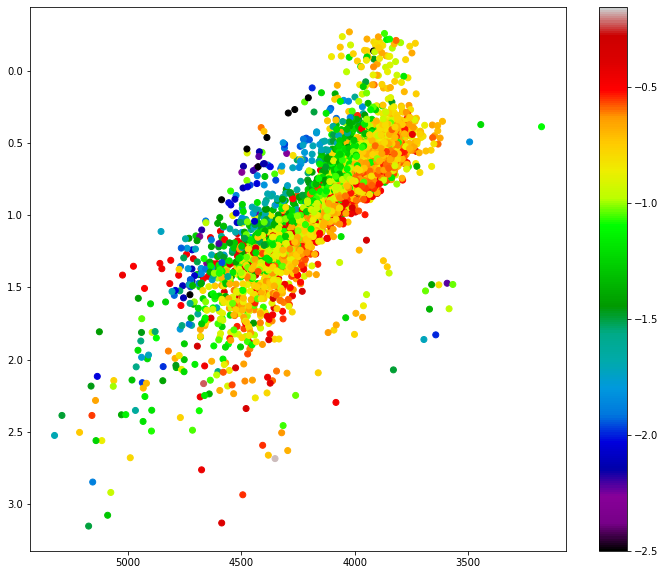

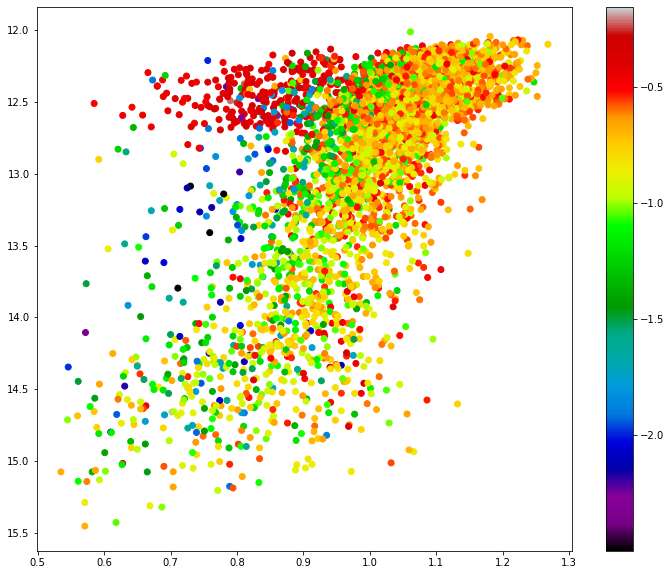

In [6]:
plt.figure(figsize=[12,10])
plt.scatter(lmc['TEFF'],lmc['LOGG'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

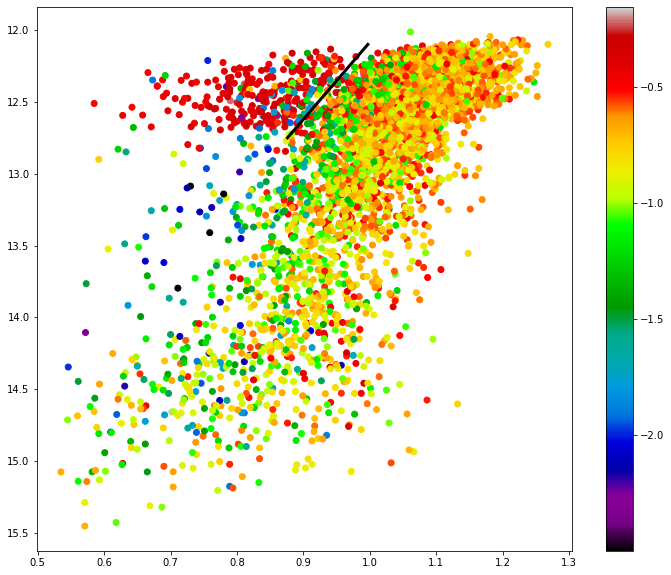

 
-5.372 x + 17.46


In [7]:
test_bloop = np.poly1d(np.polyfit([0.876,0.997],[12.75,12.1],1.))

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c=lmc['FE_H'],cmap='nipy_spectral')
plt.colorbar()
plt.plot([0.876,0.997],[test_bloop(0.876),test_bloop(0.997)],c='k',lw=3.0)
plt.gca().invert_yaxis()
plt.show()

print(test_bloop)

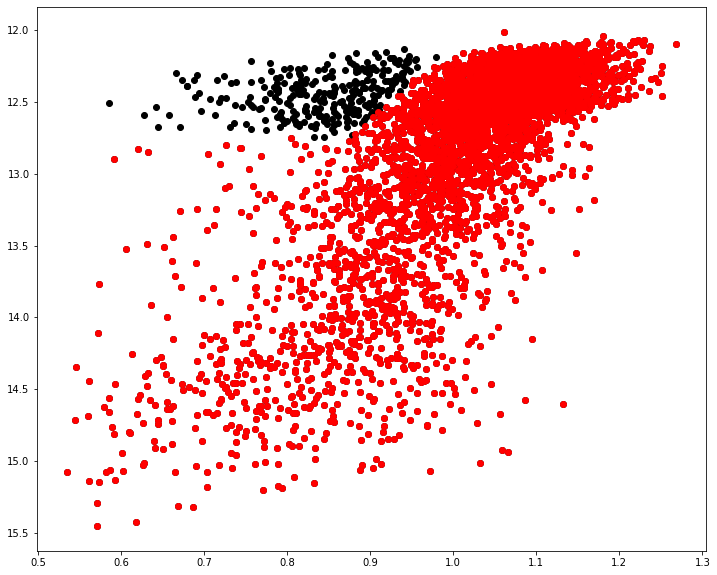

In [8]:
def bloopjkk(color):
    '''
    Function to calculate bloop boundary in J-K K space
    
    Input:
    -----
        color: J-K color
        
    Output:
    ------
        Value of cut
    '''
    x=color
    return np.piecewise(x,[x<=0.876,x>0.876],[lambda x: 12.75, lambda x: -5.372*x+17.46])

bloop_cut = np.where(lmc['K']>bloopjkk(lmc['J']-lmc['K']))

plt.figure(figsize=[12,10])
plt.scatter(lmc['J']-lmc['K'],lmc['K'],c='k')
plt.scatter((lmc['J']-lmc['K'])[bloop_cut],lmc['K'][bloop_cut],c='r')
plt.gca().invert_yaxis()
plt.show()

lmc = lmc[bloop_cut]
radius = radius[bloop_cut]
dist = dist[bloop_cut]

In [9]:
##########################
### Functions for MCMC ###
##########################

from scipy.optimize import minimize

def mad(dat):
    '''
    Calculate the median absolute deviation (MAD)
    
    Parameters:
    ----------
        dat: array-like object containing data
    
    Returns:
    -------
        dev: MAD(dat)
    '''
    dev = np.median(np.absolute(dat - np.median(dat)))
    return dev

def line(m,b,x):
    '''
    Slope-intercept form of a line
    
    Parameters:
    ----------
        m: slope of line
        x: exog of line
        b: intercept of line
        
    Returns:
    -------
        y: endog of line
    '''
    y = m*x + b
    return y

def lnL(theta,x,y,xerr,yerr):
    '''
    Log likelihood for line
    
    Parameters:
    ----------
        theta: parameters to plug into line (m,b)
        x: exog of line
        y: endog of line
        xerr: exog error
        yerr: endog error
    
    Returns:
    -------
        lnl: log likelihood 
    '''
    
    m, b = theta
    modl = line(m,b,x)
    inv_sig2 = np.reciprocal(np.square(yerr)+np.square(xerr))#+np.square(sigmodl))
    lnl = -0.5 * np.sum(np.multiply(np.square((y - modl)),inv_sig2) - np.log(inv_sig2/(2*np.pi)))
    return lnl

def lnPrior(theta):
    m, b = theta
    if -1.0 < m < 1.0 and -2.0 < b < 2.0:
        return 0.0
    return -np.inf

def lnProb(theta, x, y, xerr, yerr):
    lnP = lnPrior(theta)
    if not np.isfinite(lnP):
        return -np.inf
    return lnP + lnL(theta, x, y, xerr, yerr)

def MLELinearParameters(rad,abund,abund_err,bin_width):
    '''
    Calculate the MLE parameters for a linear abundance trend
    
    Inputs:
    ------
        rad: radial coordinate
        abund: elemental abundance
        yerr: error in y coordinate
        bin_width: width of bin
        
    Outputs:
    ------- 
        mle_m,mle_b: MLE parameters
    '''
    
    # bin data and calculate statistic and error for each bin
    bins = np.arange(np.floor(np.min(rad)),np.ceil(np.max(rad))+bin_width,bin_width)
    bin_stats, _, _ = binned_statistic(radius,abund,statistic='median',bins=bins)
    
    # get MAD of each bin
    bin_stats_err, _, _ = binned_statistic(rad,abund,statistic=lambda y: np.median(np.abs(y-np.median(y))),
                                           bins=bins)
    
    # shift radial values to center of bins
    center_rad_bins = np.delete(bin_edges,-1)+0.5*bin_width
    
    # calculate guess for MLE
    m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
    b_guess = bin_stats[0]
    
    # do MLE with log likelihood (lnL)
    nll = lambda *args: -lnL(*args)
    initial = np.array([m_guess, b_guess]) + 0.1 * np.random.randn(2)
    soln = minimize(nll, initial, args=(center_rad_bins, bin_stats, 0.5, bin_stats_err))
    mle_m, mle_b = soln.x
    
    return mle_m,mle_b

# Find Initial Gradients

In [29]:
cln = np.where(np.isfinite(lmc['C_FE'])==True)
binned_statistic(radius[cln],lmc['C_FE'][cln],statistic='median')

mle_ms = []
mle_bs = []

for i in range(len(elems)):
    cln = np.where((np.isfinite(lmc[elems[i]])==True)&(lmc[elems[i]]!=-9999.0)&(lmc['SNR']>100.))
    bins = np.arange(np.floor(np.min(radius[cln])),np.ceil(np.max(radius[cln]))+1.0,1.0)
    bin_stats, bin_edges, bin_number = binned_statistic(radius[cln],lmc[elems[i]][cln],statistic='median',
                                                        bins=bins)
    bin_stats_err, _, _ = binned_statistic(radius[cln],lmc[elems[i]][cln],
                                           statistic=lambda y: np.median(np.abs(y-np.median(y))),bins=bins)
#     bin_stats_err = []
#     for j in range(len(np.unique(bin_number))):
#         bin_j = np.where(bin_number==np.unique(bin_number)[j])
#         bin_stats_err.append(mad(lmc[elems[i]][bin_j]))
    
    center_rad_bins = np.arange(len(bin_stats))+0.5
    
    m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
    b_guess = bin_stats[0]
    
    nll = lambda *args: -lnL(*args)
    initial = np.array([m_guess, b_guess]) + 1e-3*np.random.randn(2)
    soln = minimize(nll, initial, args=(center_rad_bins,bin_stats,0.5*np.ones(len(bin_stats)),bin_stats_err))
    mle_m, mle_b = soln.x
    
    mle_ms.append(mle_m)
    mle_bs.append(mle_b)

### [C/Fe] ###


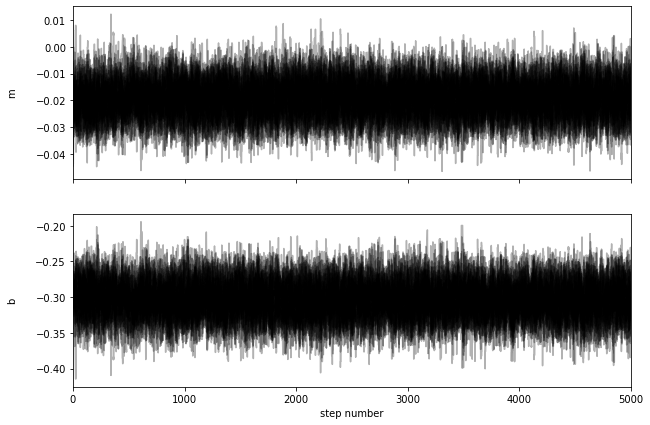

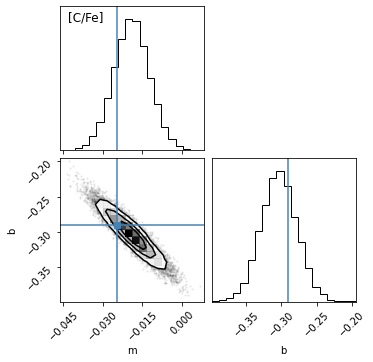

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [N/Fe] ###


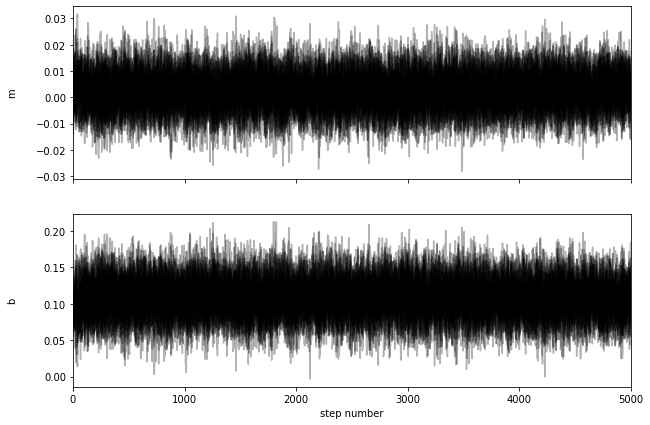

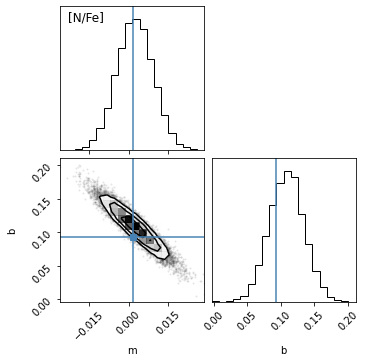

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [O/Fe] ###


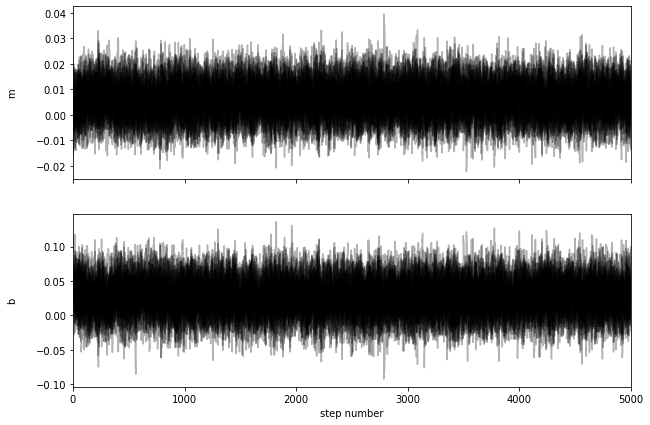

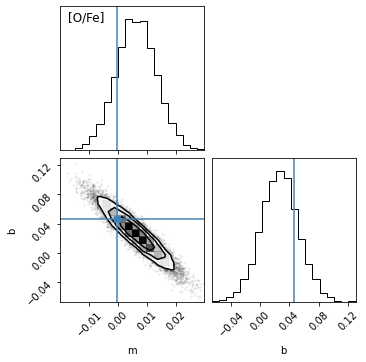

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Mg/Fe] ###


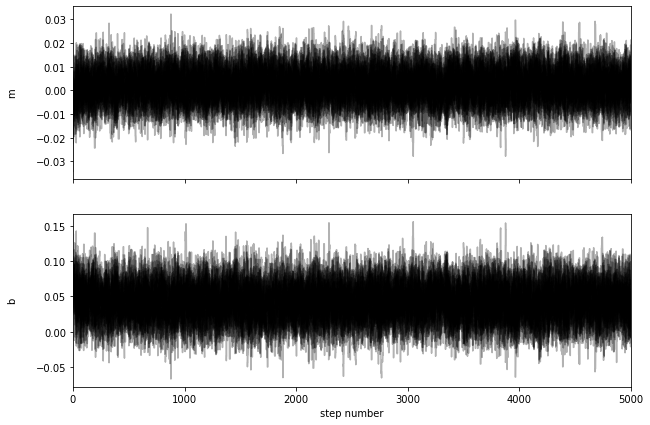

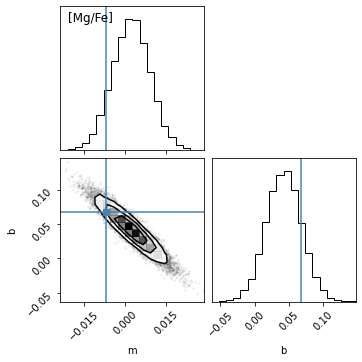

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Al/Fe] ###


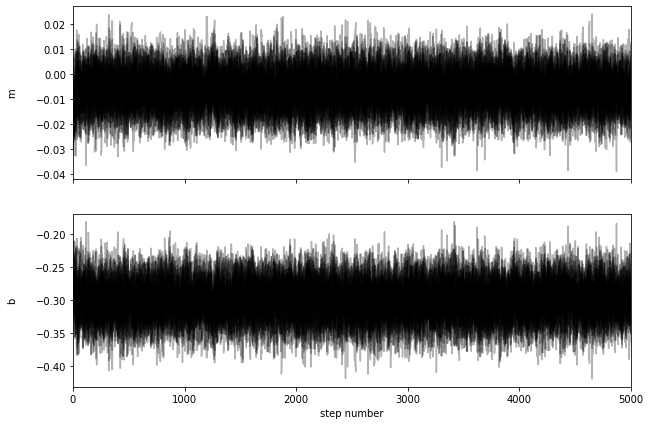

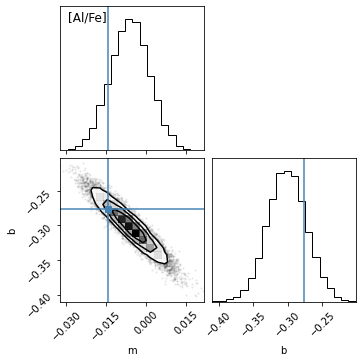

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Si/Fe] ###


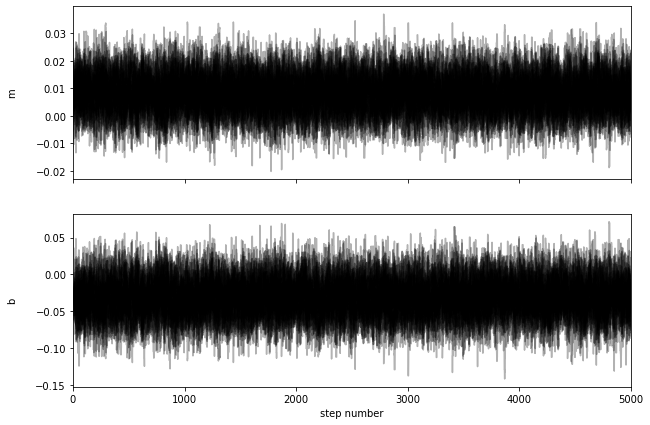

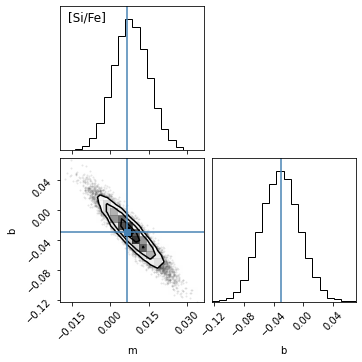

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ca/Fe] ###


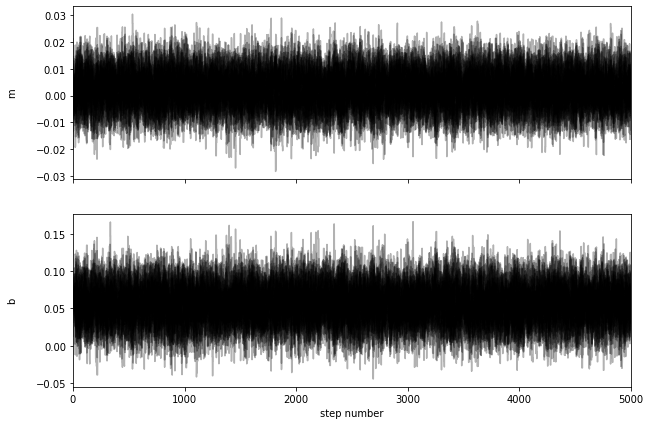

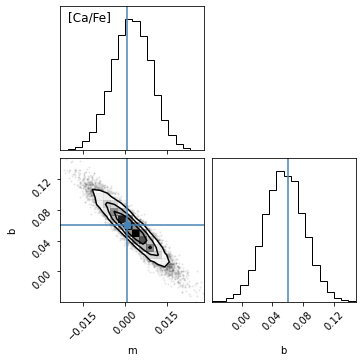

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Fe/H] ###


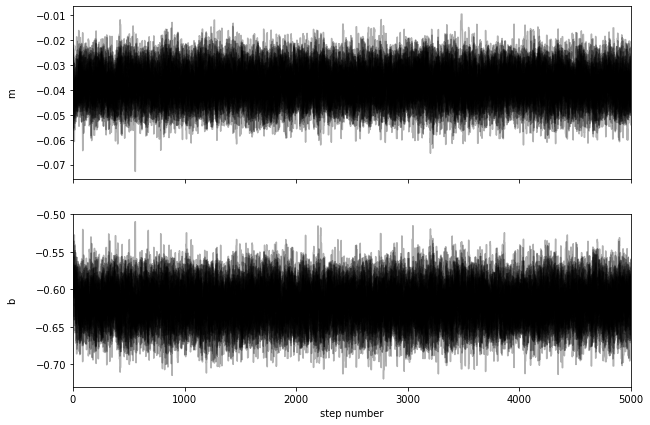

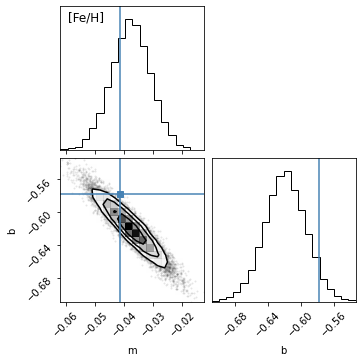

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ni/Fe] ###


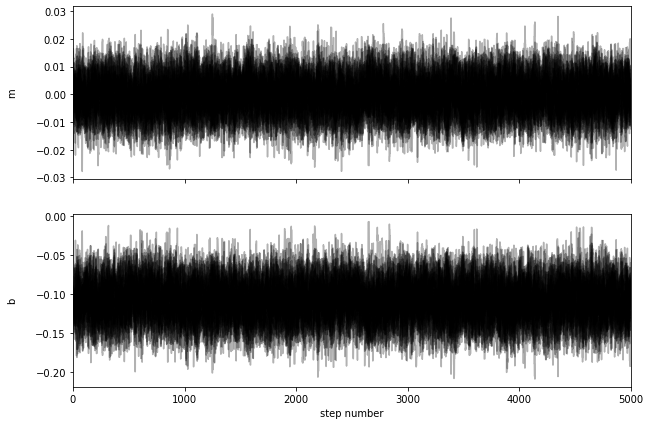

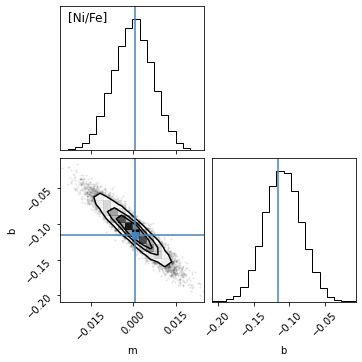

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ce/Fe] ###


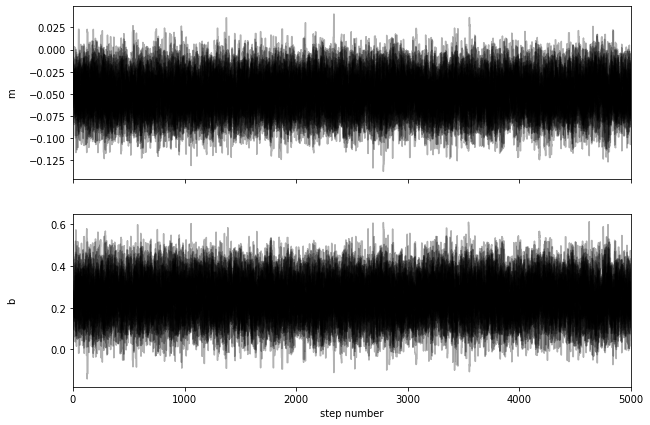

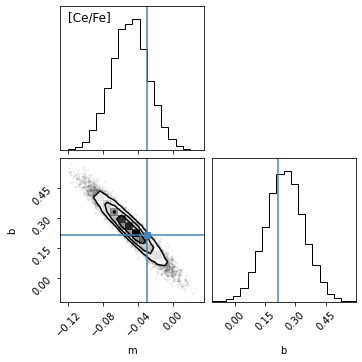

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [$\alpha$/Fe] ###


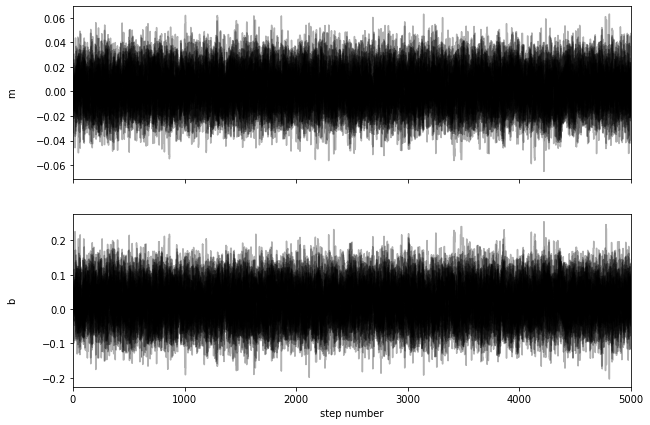

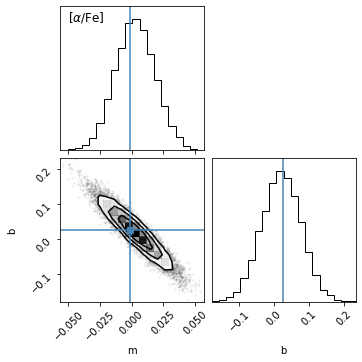

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [38]:
from IPython.display import display, Math

grads = []
grads_err = []
inter = []
inter_err = []
for i in tqdm_notebook(range(len(elems))):
    cln = np.where((np.isfinite(lmc[elems[i]])==True)&(lmc[elems[i]]!=-9999.0)&(lmc['SNR']>100.))
    pos = [mle_ms[i],mle_bs[i]]+1e-2*np.random.randn(32,2)
#     nwlakers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(pos.shape[0], pos.shape[1], lnProb, args=(radius[cln],lmc[elems[i]][cln],
                                                                  0.5*np.ones(len(lmc[cln])),
                                                                  lmc[elems[i]+'_ERR'][cln]))
    sampler.run_mcmc(pos, 5000, progress=False)
    
    print('### {} ###'.format(labs[i]))
    
    fig, axes = plt.subplots(2,figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["m", "b"]
    for j in range(pos.shape[1]):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.savefig('initial_sampler_{}'.format(elems[i]))
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    fig = corner.corner(flat_samples, labels=labels, truths=[mle_ms[i], mle_bs[i]])
    fig.text(0.2,0.89,r'{}'.format(labs[i]),fontsize=12)
    plt.savefig('initial_corner_{}'.format(elems[i]))
    plt.show()

    for k in range(pos.shape[1]):
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
        txt = txt.format(np.median(flat_samples[:,k]), mad(flat_samples[:,k]), mad(flat_samples[:,k]), labels[k])
        display(Math(txt))
        
    grads.append(np.median(flat_samples[:,0]))
    grads_err.append(mad(flat_samples[:,0]))
    inter.append(np.median(flat_samples[:,1]))
    inter_err.append(mad(flat_samples[:,1]))

In [40]:
for i in range(len(grads)):
    print('{} slope: {:.4f} +/- {:.4f}; inter: {:.4f} +/- {:.4f}'.format(elems[i],grads[i],grads_err[i],
                                                                          inter[i],inter_err[i]))

C_FE slope: -0.0192 +/- 0.0046; inter: -0.3040 +/- 0.0172
N_FE slope: 0.0023 +/- 0.0047; inter: 0.1083 +/- 0.0174
O_FE slope: 0.0061 +/- 0.0046; inter: 0.0267 +/- 0.0170
MG_FE slope: 0.0023 +/- 0.0046; inter: 0.0424 +/- 0.0174
AL_FE slope: -0.0060 +/- 0.0049; inter: -0.3010 +/- 0.0188
SI_FE slope: 0.0080 +/- 0.0047; inter: -0.0310 +/- 0.0174
CA_FE slope: 0.0025 +/- 0.0047; inter: 0.0556 +/- 0.0175
FE_H slope: -0.0378 +/- 0.0046; inter: -0.6190 +/- 0.0170
NI_FE slope: -0.0001 +/- 0.0047; inter: -0.1089 +/- 0.0177
CE_FE slope: -0.0496 +/- 0.0143; inter: 0.2473 +/- 0.0628
ALPHA_FE slope: 0.0028 +/- 0.0107; inter: 0.0205 +/- 0.0384


# 3 MAD Cut and Refit

### [C/Fe] ###


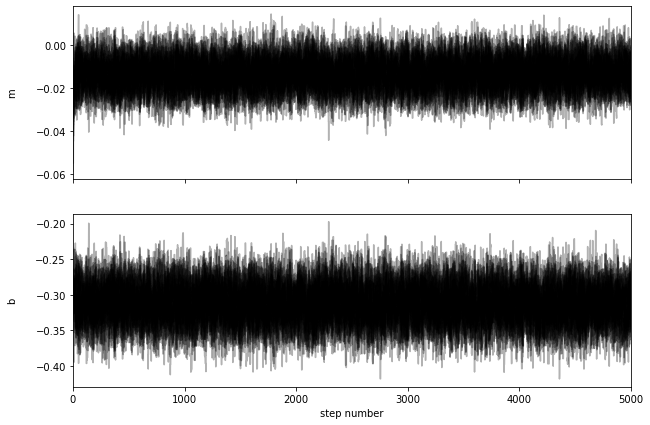

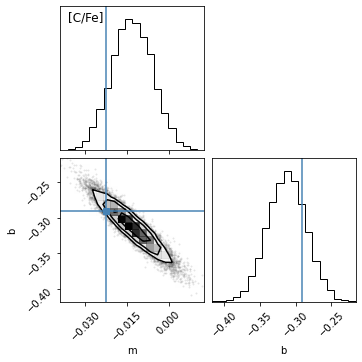

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [N/Fe] ###


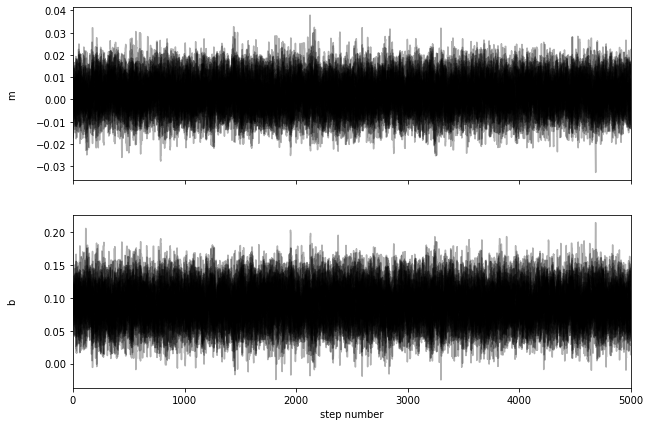

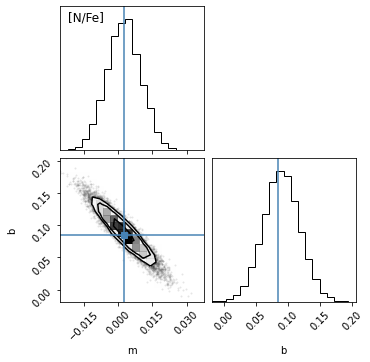

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [O/Fe] ###


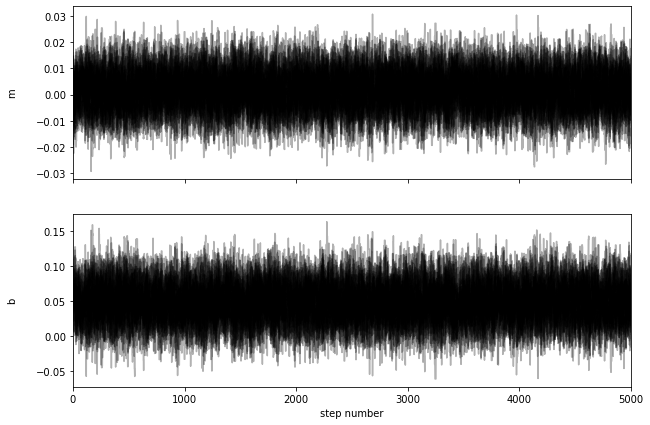

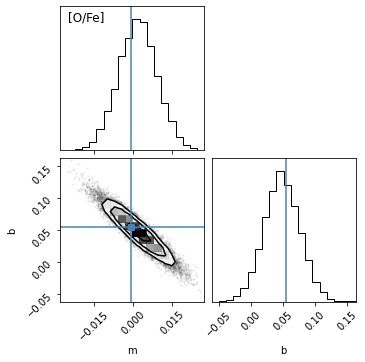

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Mg/Fe] ###


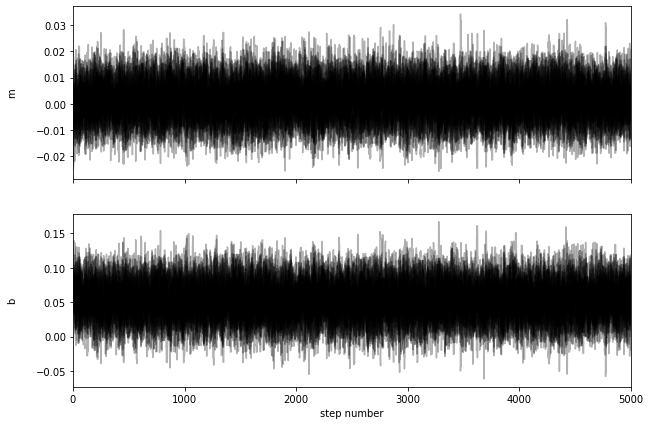

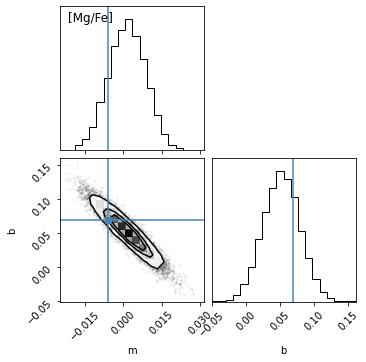

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Al/Fe] ###


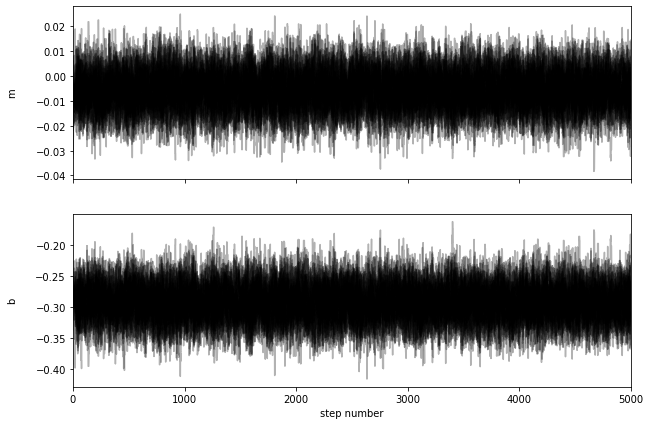

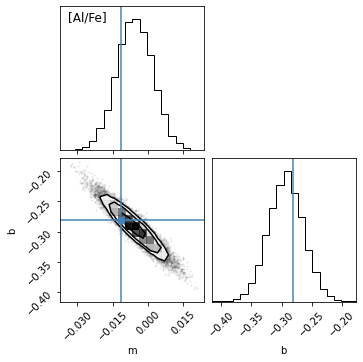

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Si/Fe] ###


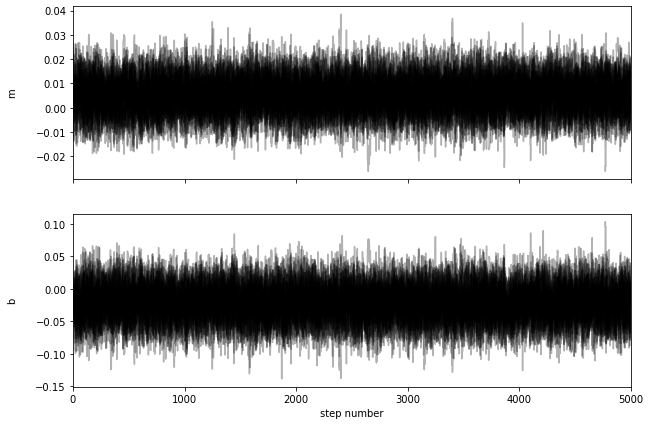

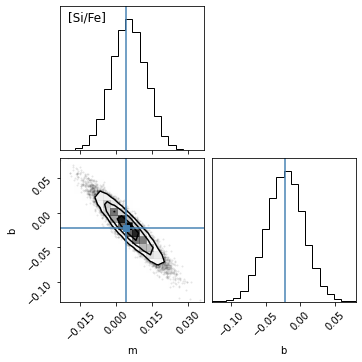

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ca/Fe] ###


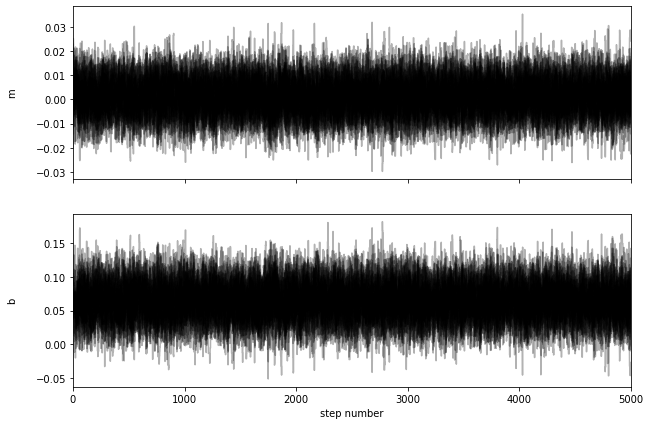

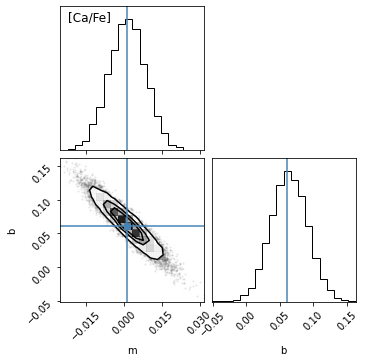

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Fe/H] ###


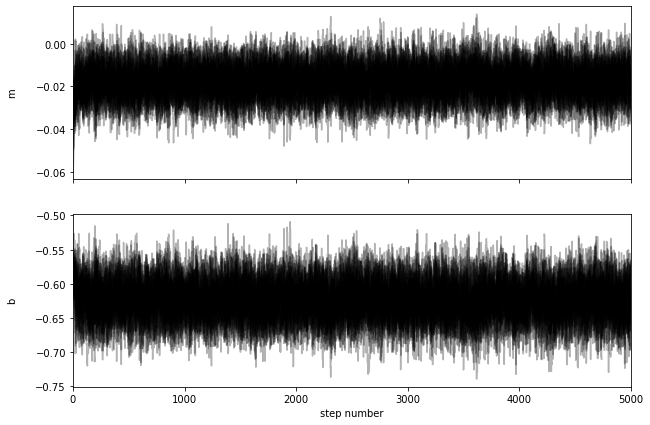

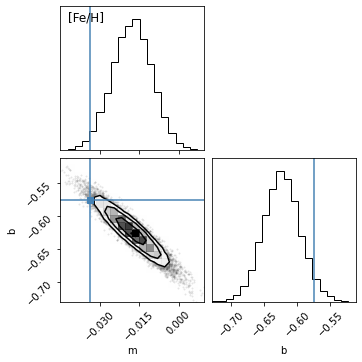

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ni/Fe] ###


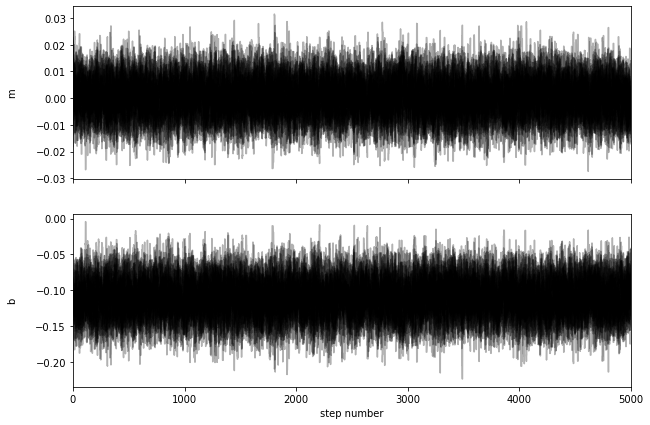

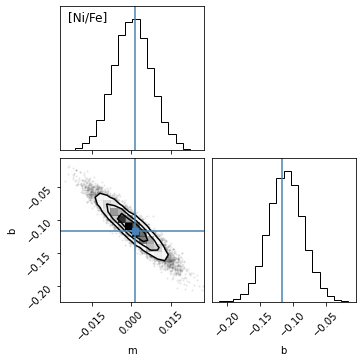

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [Ce/Fe] ###


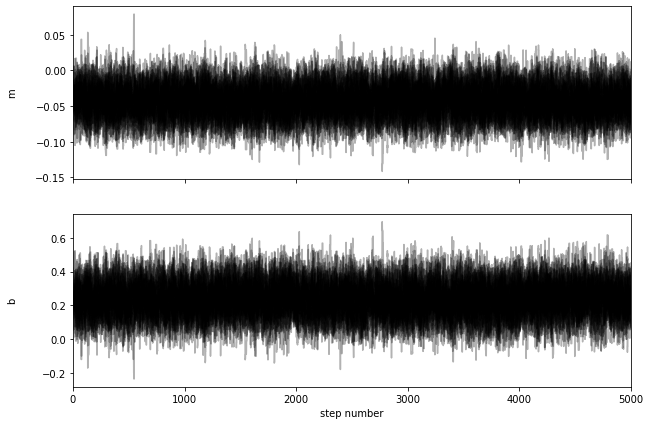

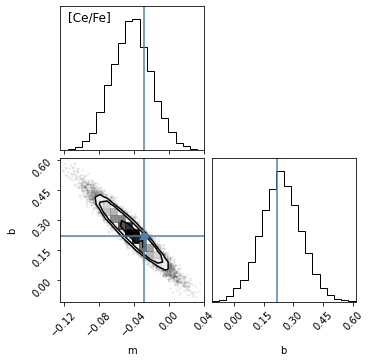

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### [$\alpha$/Fe] ###


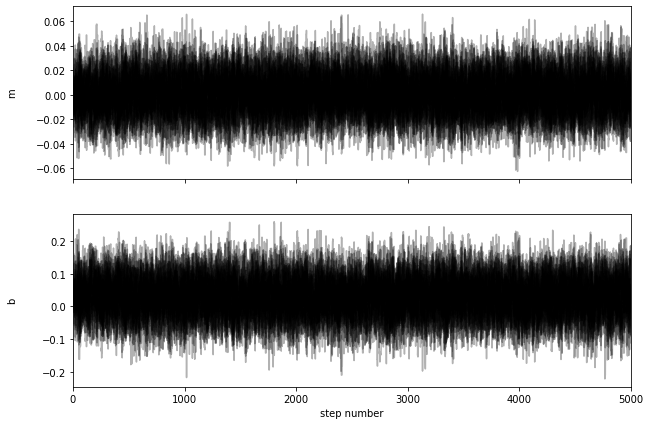

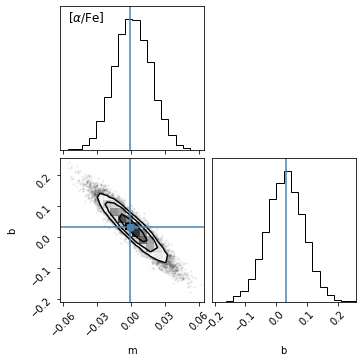

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [39]:
remle_ms = []
remle_bs = []

regrads = []
regrads_err = []
reinter = []
reinter_err = []

prune_fact = 3.
for i in tqdm_notebook(range(len(grads))):
    
    def initialmodl(x):
        return grads[i]*x+inter[i]
    
    cln = np.where((np.isfinite(lmc[elems[i]])==True)&(lmc[elems[i]]!=-9999.0)&(lmc['SNR']>100.))
    plugin = initialmodl(radius[cln])
    distmad = mad(plugin-lmc[elems[i]][cln]) 
    
    prune = np.where((lmc[elems[i]][cln]>-prune_fact*distmad+np.median(lmc[elems[i]][cln]))&
                     (lmc[elems[i]][cln]<prune_fact*distmad+np.median(lmc[elems[i]][cln]))) 
    
    prune_radius = radius[cln][prune]
    prune_abund = lmc[elems[i]][cln][prune]
    prune_abund_err = lmc[elems[i]+'_ERR'][cln][prune]
    
    bins = np.arange(np.floor(np.min(prune_radius)),np.ceil(np.max(prune_radius))+1.0,1.0)
    bin_stats, bin_edges, bin_number = binned_statistic(prune_radius,prune_abund,statistic='median',bins=bins)
    bin_stats_err, _, _ = binned_statistic(prune_radius,prune_abund,
                                           statistic=lambda y: np.median(np.abs(y-np.median(y))),bins=bins)
#     bin_stats_err = []
#     for j in range(len(np.unique(bin_number))):
#         bin_j = np.where(bin_number==np.unique(bin_number)[j])
#         bin_stats_err.append(mad(prune_abund[bin_j]))
    
    center_rad_bins = np.arange(len(bin_stats))+0.5
    
    m_guess = (bin_stats[1]-bin_stats[0])/(center_rad_bins[1]-center_rad_bins[0])
    b_guess = bin_stats[0]
    
    nll = lambda *args: -lnL(*args)
    initial = np.array([m_guess, b_guess]) + 1e-3*np.random.randn(2)
    soln = minimize(nll, initial, args=(center_rad_bins,bin_stats,0.5*np.ones(len(bin_stats)),bin_stats_err))
    mle_m, mle_b = soln.x
    
    remle_ms.append(mle_m)
    remle_bs.append(mle_b)
    
    pos = [mle_m,mle_b]+1e-2*np.random.randn(32,2)
    
    sampler = emcee.EnsembleSampler(pos.shape[0], pos.shape[1], lnProb, args=(prune_radius,prune_abund,
                                                                  0.5*np.ones(len(prune_radius)),
                                                                  prune_abund_err))
    sampler.run_mcmc(pos, 5000, progress=False)
    
    print('### {} ###'.format(labs[i]))
    
    fig, axes = plt.subplots(2,figsize=(10, 7), sharex=True)
    samples = sampler.get_chain()
    labels = ["m", "b"]
    for j in range(pos.shape[1]):
        ax = axes[j]
        ax.plot(samples[:, :, j], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[j])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    plt.savefig('refit_sampler_{}'.format(elems[i]))
    
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    
    fig = corner.corner(flat_samples, labels=labels, truths=[mle_m, mle_b])
    fig.text(0.2,0.89,r'{}'.format(labs[i]),fontsize=12)
    plt.savefig('refit_corner_{}'.format(elems[i]))
    plt.show()

    for k in range(pos.shape[1]):
        txt = "\mathrm{{{3}}} = {0:.4f}_{{-{1:.4f}}}^{{{2:.4f}}}"
        txt = txt.format(np.median(flat_samples[:,k]), mad(flat_samples[:,k]), mad(flat_samples[:,k]), labels[k])
        display(Math(txt))
        
    regrads.append(np.median(flat_samples[:,0]))
    regrads_err.append(mad(flat_samples[:,0]))
    reinter.append(np.median(flat_samples[:,1]))
    reinter_err.append(mad(flat_samples[:,1]))

In [41]:
for i in range(len(regrads)):
    print('{} slope: {:.4f} +/- {:.4f}; inter: {:.4f} +/- {:.4f}'.format(elems[i],regrads[i],regrads_err[i],
                                                                          reinter[i],reinter_err[i]))

C_FE slope: -0.0133 +/- 0.0050; inter: -0.3123 +/- 0.0183
N_FE slope: 0.0025 +/- 0.0050; inter: 0.0898 +/- 0.0186
O_FE slope: 0.0019 +/- 0.0050; inter: 0.0480 +/- 0.0189
MG_FE slope: 0.0015 +/- 0.0050; inter: 0.0521 +/- 0.0183
AL_FE slope: -0.0056 +/- 0.0052; inter: -0.2929 +/- 0.0195
SI_FE slope: 0.0051 +/- 0.0048; inter: -0.0215 +/- 0.0177
CA_FE slope: 0.0014 +/- 0.0049; inter: 0.0638 +/- 0.0183
FE_H slope: -0.0176 +/- 0.0051; inter: -0.6237 +/- 0.0184
NI_FE slope: 0.0004 +/- 0.0048; inter: -0.1111 +/- 0.0177
CE_FE slope: -0.0430 +/- 0.0152; inter: 0.2368 +/- 0.0680
ALPHA_FE slope: 0.0012 +/- 0.0111; inter: 0.0293 +/- 0.0399
